In [3]:
%cd /Users/user/Desktop/IWF-DNN/data2DComplex
%pwd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import scipy.io as sio
import time
from sklearn.cross_validation import train_test_split
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/Users/user/Desktop/IWF-DNN/data2DComplex


In [49]:
DateLocation='MIMO100000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=Data['X']
Ydata=Data['Y']
Xdata = np.transpose(Xdata)
Ydata = np.transpose(Ydata)
X = np.column_stack((np.real(Xdata), np.imag(Xdata)))
Y = np.column_stack((np.real(Ydata), np.imag(Ydata)))
x_train, x_val ,y_train, y_val= train_test_split(X, Y, test_size=0.1)
DateLocation2='MIMO5000_3.mat'
DataTest10000 = sio.loadmat(DateLocation2)#load data
Xtest=DataTest10000['X']
Xtest = np.transpose(Xtest)
Ytest=DataTest10000['Y']
Ytest = np.transpose(Ytest)
Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

In [58]:
import time
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[K,M,N])
        pnn=np.reshape(y_pred[i,:],[K,M,N])      
        for j in range(K):
            if j==0:
                rate_nn = rate_nn+np.real(np.log2( \
                                                  np.linalg.det(np.eye(N)+np.dot(np.dot(H[j,:,:].conj(),np.transpose(pnn[j,:,:])), np.transpose(H[j,:,:])))))
            else:
                pnn[j,:,:]=np.transpose(pnn[j,:,:])+pnn[j-1,:,:]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(N)+np.dot(np.dot(H[j,:,:].conj(), pnn[j,:,:]), np.transpose(H[j,:,:]))) \
                                                  /np.linalg.det((np.eye(N)+np.dot(np.dot(H[j,:,:].conj(),pnn[j-1,:,:]),np.transpose(H[j,:,:]))))))
                
        sum_rate.append(rate_nn)
    return sum_rate
def power(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    powerall=[]
    for i in range(samples):
        power=0
        H=np.reshape(xtest[i,:],[K,M,N])
#         print(y_pred[i,:])
        pnn=np.reshape(y_pred[i,:],[K,M,N])  
#         print(pnn)
        for j in range(K):
            power=power+np.trace(np.transpose(pnn[j,:,:]))
        powerall.append(np.real(power))
    return powerall

def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, n_hidden_4 = 40,binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_output)
    pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred

def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X

def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))
    
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0

def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 15])
#     plt.xlim([9.8, 10.2])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.legend()
    plt.show()
    return 0
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0
def testPerformance(model, Xtest,x_train,x_val,y_train,y_val,Ytest,dim, M, N, K,samples):
    ypred=model.predict(Xtest)
    trainPred=model.predict(x_train)
    valPred=model.predict(x_val)
    # transfer 24 dimensions data to 12 dimension
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)
    # draw the CDF curve of two algorithm
    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(211)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(212)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
#     plt.subplot(313)
#     plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    # draw histgram for two algorithm
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    # calculate the average sum rate of two algorithm
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0


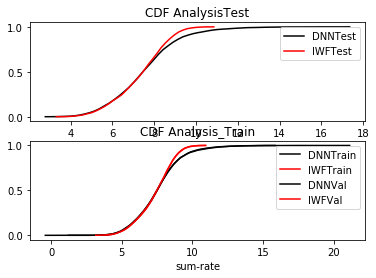

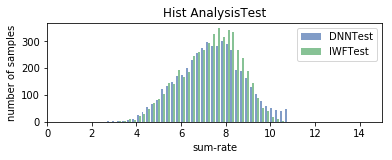

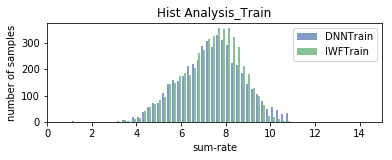

Sum-rate: IWF: 7.326, DNN: 7.523
Ratio: DNN: 102.685%

Sum-rate: IWF: 7.363, DNN: 7.548
Ratio: DNN: 102.512%



0

In [40]:
# 5 layers 600-480-...S
testPerformance(model5layers2, Xtest,x_train,x_val,y_train,y_val,Ytest,12, 2,2, 3,5000)

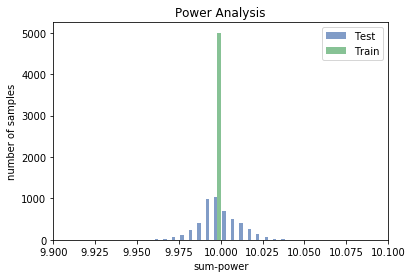

0

In [69]:
def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate1),2000)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
#     plt.xlim([0, 15])
    plt.xlim([9.9, 10.1])
    plt.xlabel('sum-power')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.legend()
    plt.show()
    return 0
ypred=model5layers2.predict(Xtest)
xtest=DABtoComplex(Xtest,12)
ypred=DABtoComplex(ypred,12)
histTest=power(xtest, ypred,2,2,3, 5000)


xtrain=DABtoComplex(x_train,12)
ytrain=DABtoComplex(y_train,12)
histTrain=power(xtrain, ytrain,2,2,3, 5000)
plt.figure(3)
# plt.subplot(211)
plt.title('Power Analysis')
histPlot(histTest,histTrain,label=['Test', 'Train'])
# plt.xlim([9, 11])

In [62]:
np.linspace(0, max(histTrain),10)

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [63]:
max(histTrain)

10.000000000000057

In [55]:
histTrain

[10.000000000000007,
 10.000000000000004,
 10.000000000000004,
 9.999999999999998,
 10.000000000000018,
 10.000000000000005,
 10.000000000000025,
 10.000000000000005,
 10.000000000000007,
 9.999999999999996,
 9.999999999999995,
 10.000000000000002,
 9.999999999999996,
 9.99999999999999,
 9.999999999999986,
 10.0,
 9.999999999999986,
 9.999999999999996,
 9.999999999999996,
 10.000000000000002,
 10.0,
 10.0,
 9.99999999999999,
 9.999999999999993,
 10.000000000000004,
 9.999999999999995,
 10.000000000000005,
 9.999999999999996,
 9.999999999999996,
 10.000000000000004,
 10.0,
 10.0,
 10.0,
 10.000000000000005,
 9.999999999999998,
 10.000000000000007,
 10.000000000000004,
 10.000000000000016,
 10.000000000000028,
 9.999999999999986,
 9.999999999999993,
 10.0,
 9.999999999999996,
 9.999999999999996,
 9.999999999999995,
 10.000000000000004,
 9.999999999999996,
 9.999999999999991,
 9.999999999999996,
 10.000000000000002,
 10.000000000000002,
 9.999999999999998,
 10.0,
 9.999999999999996,
 10.0

In [12]:
def plot_whole(dict_data):
    fig_1 = plt.figure(figsize=(16,5))
    ax_1 = fig_1.add_subplot(1,2,1)
    ax_2 = fig_1.add_subplot(1,2,2)
    k =int(0)
    for data in dict_data.values():
        ax_1.plot(np.arange(0,len(data['loss'])),data['loss'], label=list(dict_data.keys())[k])
        ax_2.plot(np.arange(0,len(data['val_loss'])),data['val_loss'], label=list(dict_data.keys())[k])
        k += 1
    ax_1.legend(loc=0)
    
    ax_2.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('error(train)')
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('error(valid)')
    fig_1.savefig('err.pdf')
    return fig_1, ax_1, ax_2

In [9]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model5layers = Sequential()
# activation=keras.layers.ReLU()
model5layers.add(Dense(240, input_dim=24, activation='relu'))
model5layers.add(Dense(480, activation='relu'))
model5layers.add(Dense(240, activation='relu'))
model5layers.add(Dense(120, activation='relu'))
model5layers.add(Dense(60, activation='relu'))
model5layers.add(Dense(24, activation='linear'))
model5layers.summary()
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model5layers.compile(loss='mse', optimizer=adam)
hist=model5layers.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-240-480-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 240)               6000      
_________________________________________________________________
dense_14 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_15 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_16 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_17 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_18 (Dense)             (None, 24)                1464      
Total params: 274,764
Trainable params: 274,764
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 13s 141us/step - loss: 0.0428 - val_loss: 0.2138
Epoch 66/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0442 - val_loss: 0.2215
Epoch 67/200
90000/90000 [==============================] - 13s 140us/step - loss: 0.0431 - val_loss: 0.2144
Epoch 68/200
90000/90000 [==============================] - 15s 167us/step - loss: 0.0431 - val_loss: 0.2081
Epoch 69/200
90000/90000 [==============================] - 17s 190us/step - loss: 0.0423 - val_loss: 0.2199
Epoch 70/200
90000/90000 [==============================] - 16s 174us/step - loss: 0.0409 - val_loss: 0.2085
Epoch 71/200
90000/90000 [==============================] - 22s 241us/step - loss: 0.0413 - val_loss: 0.2120
Epoch 72/200
90000/90000 [==============================] - 21s 228us/step - loss: 0.0424 - val_loss: 0.2189
Epoch 73/200
90000/90000 [==============================] - 18s 196us/step - loss: 0.0410 - val_loss: 0.2133
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 16s 182us/step - loss: 0.0297 - val_loss: 0.2065
Epoch 141/200
90000/90000 [==============================] - 13s 149us/step - loss: 0.0300 - val_loss: 0.2195
Epoch 142/200
90000/90000 [==============================] - 16s 180us/step - loss: 0.0284 - val_loss: 0.2051
Epoch 143/200
90000/90000 [==============================] - 15s 164us/step - loss: 0.0300 - val_loss: 0.2160
Epoch 144/200
90000/90000 [==============================] - 15s 165us/step - loss: 0.0289 - val_loss: 0.2099
Epoch 145/200
90000/90000 [==============================] - 15s 169us/step - loss: 0.0298 - val_loss: 0.2023
Epoch 146/200
90000/90000 [==============================] - 17s 190us/step - loss: 0.0294 - val_loss: 0.2046
Epoch 147/200
90000/90000 [==============================] - 16s 182us/step - loss: 0.0289 - val_loss: 0.2141
Epoch 148/200
90000/90000 [==============================] - 17s 191us/step - loss: 0.0283 - val_loss: 0.2018
Epoch 149/

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2ff6bf60>)

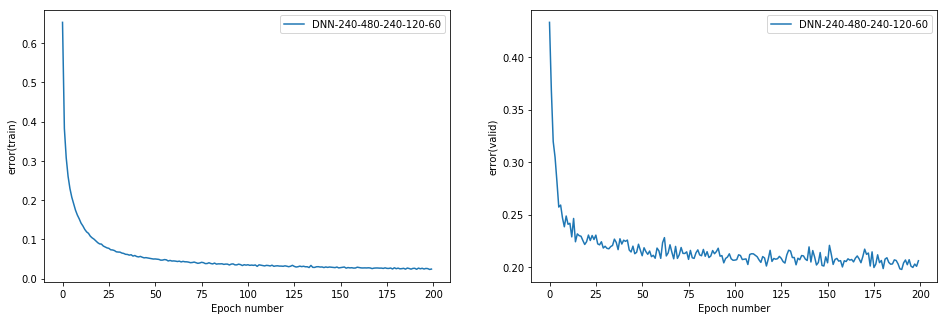

In [13]:
plot_whole(dictData)

In [14]:
model5layers3 = Sequential()
# activation=keras.layers.ReLU()
model5layers3.add(Dense(480, input_dim=24, activation='relu'))
model5layers3.add(Dense(360, activation='relu'))
model5layers3.add(Dense(240, activation='relu'))
model5layers3.add(Dense(120, activation='relu'))
model5layers3.add(Dense(60, activation='relu'))
model5layers3.add(Dense(24, activation='linear'))
model5layers3.summary()
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model5layers3.compile(loss='mse', optimizer=adam)
hist=model5layers3.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-480-360-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 480)               12000     
_________________________________________________________________
dense_26 (Dense)             (None, 360)               173160    
_________________________________________________________________
dense_27 (Dense)             (None, 240)               86640     
_________________________________________________________________
dense_28 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_29 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_30 (Dense)             (None, 24)                1464      
Total params: 309,444
Trainable params: 309,444
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 26s 284us/step - loss: 0.0385 - val_loss: 0.1802
Epoch 66/200
90000/90000 [==============================] - 25s 282us/step - loss: 0.0390 - val_loss: 0.1829
Epoch 67/200
90000/90000 [==============================] - 26s 291us/step - loss: 0.0378 - val_loss: 0.1808
Epoch 68/200
90000/90000 [==============================] - 25s 282us/step - loss: 0.0401 - val_loss: 0.1841
Epoch 69/200
90000/90000 [==============================] - 25s 279us/step - loss: 0.0368 - val_loss: 0.1836
Epoch 70/200
90000/90000 [==============================] - 25s 278us/step - loss: 0.0384 - val_loss: 0.1790
Epoch 71/200
90000/90000 [==============================] - 25s 278us/step - loss: 0.0378 - val_loss: 0.1865
Epoch 72/200
90000/90000 [==============================] - 25s 277us/step - loss: 0.0374 - val_loss: 0.1733
Epoch 73/200
90000/90000 [==============================] - 25s 277us/step - loss: 0.0351 - val_loss: 0.1767
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 14s 156us/step - loss: 0.0272 - val_loss: 0.1775
Epoch 141/200
90000/90000 [==============================] - 14s 156us/step - loss: 0.0265 - val_loss: 0.1639
Epoch 142/200
90000/90000 [==============================] - 14s 155us/step - loss: 0.0287 - val_loss: 0.1701
Epoch 143/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0257 - val_loss: 0.1735
Epoch 144/200
90000/90000 [==============================] - 14s 156us/step - loss: 0.0265 - val_loss: 0.1647
Epoch 145/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0256 - val_loss: 0.1658
Epoch 146/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0267 - val_loss: 0.1720
Epoch 147/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0260 - val_loss: 0.1762
Epoch 148/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0263 - val_loss: 0.1755
Epoch 149/

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3096bba8>)

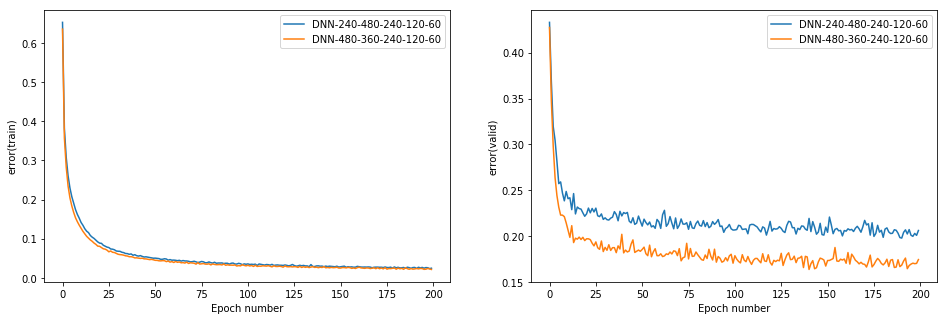

In [15]:
plot_whole(dictData)

In [16]:
model5layers2 = Sequential()
# activation=keras.layers.ReLU()
model5layers2.add(Dense(600, input_dim=24, activation='relu'))
model5layers2.add(Dense(480, activation='relu'))
model5layers2.add(Dense(240, activation='relu'))
model5layers2.add(Dense(120, activation='relu'))
model5layers2.add(Dense(60, activation='relu'))
model5layers2.add(Dense(24, activation='linear'))
model5layers2.summary()
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model5layers2.compile(loss='mse', optimizer=adam)
hist=model5layers2.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-600-480-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 600)               15000     
_________________________________________________________________
dense_32 (Dense)             (None, 480)               288480    
_________________________________________________________________
dense_33 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_34 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_35 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_36 (Dense)             (None, 24)                1464      
Total params: 456,564
Trainable params: 456,564
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 20s 223us/step - loss: 0.0337 - val_loss: 0.1749
Epoch 66/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0370 - val_loss: 0.1712
Epoch 67/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0331 - val_loss: 0.1674
Epoch 68/200
90000/90000 [==============================] - 20s 223us/step - loss: 0.0348 - val_loss: 0.1680
Epoch 69/200
90000/90000 [==============================] - 20s 221us/step - loss: 0.0347 - val_loss: 0.1700
Epoch 70/200
90000/90000 [==============================] - 20s 223us/step - loss: 0.0323 - val_loss: 0.1647
Epoch 71/200
90000/90000 [==============================] - 20s 221us/step - loss: 0.0355 - val_loss: 0.1727
Epoch 72/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0322 - val_loss: 0.1649
Epoch 73/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0332 - val_loss: 0.1700
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0232 - val_loss: 0.1636
Epoch 141/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0223 - val_loss: 0.1634
Epoch 142/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0229 - val_loss: 0.1660
Epoch 143/200
90000/90000 [==============================] - 20s 223us/step - loss: 0.0226 - val_loss: 0.1618
Epoch 144/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0214 - val_loss: 0.1633
Epoch 145/200
90000/90000 [==============================] - 20s 221us/step - loss: 0.0227 - val_loss: 0.1622
Epoch 146/200
90000/90000 [==============================] - 20s 224us/step - loss: 0.0218 - val_loss: 0.1609
Epoch 147/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0221 - val_loss: 0.1645
Epoch 148/200
90000/90000 [==============================] - 20s 222us/step - loss: 0.0241 - val_loss: 0.1574
Epoch 149/

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a313956a0>)

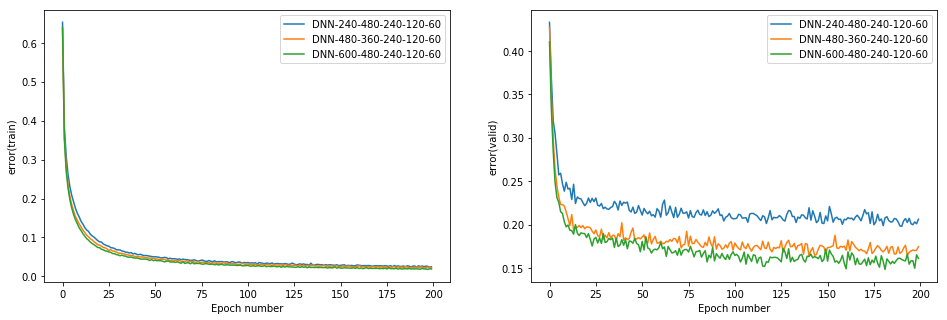

In [17]:
plot_whole(dictData)

# Complex Number Format: RIRI / RRII

In [21]:
DateLocation='MIMOComplex100000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=Data['XX']
Ydata=Data['YY']
Xdata = np.transpose(Xdata)
Ydata = np.transpose(Ydata)
# X = np.column_stack((np.real(Xdata), np.imag(Xdata)))
# Y = np.column_stack((np.real(Ydata), np.imag(Ydata)))
x_train, x_val ,y_train, y_val= train_test_split(Xdata, Ydata, test_size=0.1)

In [22]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model5layers5 = Sequential()
# activation=keras.layers.ReLU()
model5layers5.add(Dense(600, input_dim=24, activation='relu'))
model5layers5.add(Dense(480, activation='relu'))
model5layers5.add(Dense(240, activation='relu'))
model5layers5.add(Dense(120, activation='relu'))
model5layers5.add(Dense(60, activation='relu'))
model5layers5.add(Dense(24, activation='linear'))
model5layers5.summary()
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model5layers5.compile(loss='mse', optimizer=adam)
hist=model5layers5.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['RIRI']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 600)               15000     
_________________________________________________________________
dense_44 (Dense)             (None, 480)               288480    
_________________________________________________________________
dense_45 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_46 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_47 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_48 (Dense)             (None, 24)                1464      
Total params: 456,564
Trainable params: 456,564
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 25s 279us/step - loss: 0.0343 - val_loss: 0.1741
Epoch 66/200
90000/90000 [==============================] - 24s 264us/step - loss: 0.0346 - val_loss: 0.1734
Epoch 67/200
90000/90000 [==============================] - 26s 293us/step - loss: 0.0338 - val_loss: 0.1718
Epoch 68/200
90000/90000 [==============================] - 24s 269us/step - loss: 0.0313 - val_loss: 0.1798
Epoch 69/200
90000/90000 [==============================] - 23s 257us/step - loss: 0.0343 - val_loss: 0.1748
Epoch 70/200
90000/90000 [==============================] - 25s 279us/step - loss: 0.0324 - val_loss: 0.1672
Epoch 71/200
90000/90000 [==============================] - 25s 273us/step - loss: 0.0342 - val_loss: 0.1700
Epoch 72/200
90000/90000 [==============================] - 24s 269us/step - loss: 0.0313 - val_loss: 0.1765
Epoch 73/200
90000/90000 [==============================] - 23s 260us/step - loss: 0.0325 - val_loss: 0.1751
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 26s 290us/step - loss: 0.0231 - val_loss: 0.1708
Epoch 141/200
90000/90000 [==============================] - 33s 369us/step - loss: 0.0219 - val_loss: 0.1676
Epoch 142/200
90000/90000 [==============================] - 28s 312us/step - loss: 0.0198 - val_loss: 0.1682
Epoch 143/200
90000/90000 [==============================] - 27s 298us/step - loss: 0.0233 - val_loss: 0.1644
Epoch 144/200
90000/90000 [==============================] - 28s 311us/step - loss: 0.0216 - val_loss: 0.1721
Epoch 145/200
90000/90000 [==============================] - 28s 307us/step - loss: 0.0219 - val_loss: 0.1631
Epoch 146/200
90000/90000 [==============================] - 28s 313us/step - loss: 0.0205 - val_loss: 0.1633
Epoch 147/200
90000/90000 [==============================] - 27s 297us/step - loss: 0.0209 - val_loss: 0.1602
Epoch 148/200
90000/90000 [==============================] - 25s 275us/step - loss: 0.0220 - val_loss: 0.1703
Epoch 149/

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a26833400>)

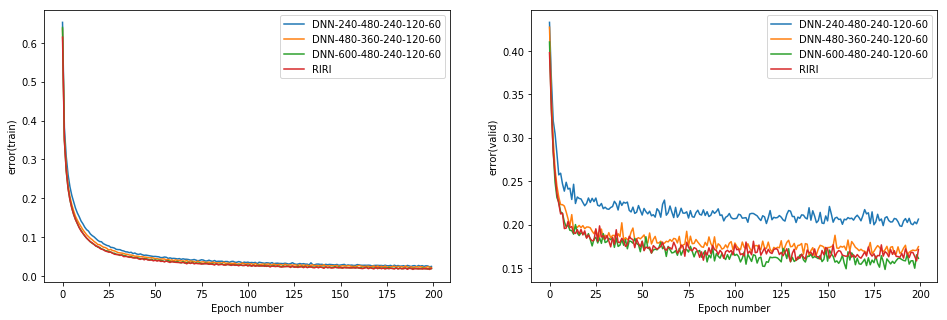

In [23]:
plot_whole(dictData)

In [26]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model5layers = Sequential()
# activation=keras.layers.ReLU()
model5layers.add(Dense(240, input_dim=24, activation='relu'))
model5layers.add(Dense(480, activation='relu'))
model5layers.add(Dense(240, activation='relu'))
model5layers.add(Dense(120, activation='relu'))
model5layers.add(Dense(60, activation='relu'))
model5layers.add(Dense(24, activation='linear'))
model5layers.summary()
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model5layers.compile(loss='mse', optimizer=adam)
hist=model5layers.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['RIRI-240-480-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 240)               6000      
_________________________________________________________________
dense_50 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_51 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_52 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_53 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_54 (Dense)             (None, 24)                1464      
Total params: 274,764
Trainable params: 274,764
Non-trainable params: 0
_________________________________________________________________
Trai

90000/90000 [==============================] - 13s 141us/step - loss: 0.0450 - val_loss: 0.2143
Epoch 66/200
90000/90000 [==============================] - 13s 140us/step - loss: 0.0433 - val_loss: 0.2041
Epoch 67/200
90000/90000 [==============================] - 13s 140us/step - loss: 0.0435 - val_loss: 0.2144
Epoch 68/200
90000/90000 [==============================] - 13s 139us/step - loss: 0.0437 - val_loss: 0.2096
Epoch 69/200
90000/90000 [==============================] - 13s 141us/step - loss: 0.0423 - val_loss: 0.2095
Epoch 70/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0424 - val_loss: 0.2057
Epoch 71/200
90000/90000 [==============================] - 13s 141us/step - loss: 0.0417 - val_loss: 0.2019
Epoch 72/200
90000/90000 [==============================] - 13s 142us/step - loss: 0.0419 - val_loss: 0.2167
Epoch 73/200
90000/90000 [==============================] - 13s 140us/step - loss: 0.0409 - val_loss: 0.2073
Epoch 74/200
90000/90000 [======

Epoch 140/200
90000/90000 [==============================] - 17s 187us/step - loss: 0.0296 - val_loss: 0.1977
Epoch 141/200
90000/90000 [==============================] - 17s 185us/step - loss: 0.0295 - val_loss: 0.1970
Epoch 142/200
90000/90000 [==============================] - 17s 187us/step - loss: 0.0289 - val_loss: 0.1989
Epoch 143/200
90000/90000 [==============================] - 17s 190us/step - loss: 0.0286 - val_loss: 0.1970
Epoch 144/200
90000/90000 [==============================] - 17s 189us/step - loss: 0.0296 - val_loss: 0.2006
Epoch 145/200
90000/90000 [==============================] - 17s 193us/step - loss: 0.0298 - val_loss: 0.1981
Epoch 146/200
90000/90000 [==============================] - 17s 191us/step - loss: 0.0276 - val_loss: 0.1921
Epoch 147/200
90000/90000 [==============================] - 17s 194us/step - loss: 0.0302 - val_loss: 0.1994
Epoch 148/200
90000/90000 [==============================] - 17s 191us/step - loss: 0.0300 - val_loss: 0.2034
Epoch 149/

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a27edbf28>)

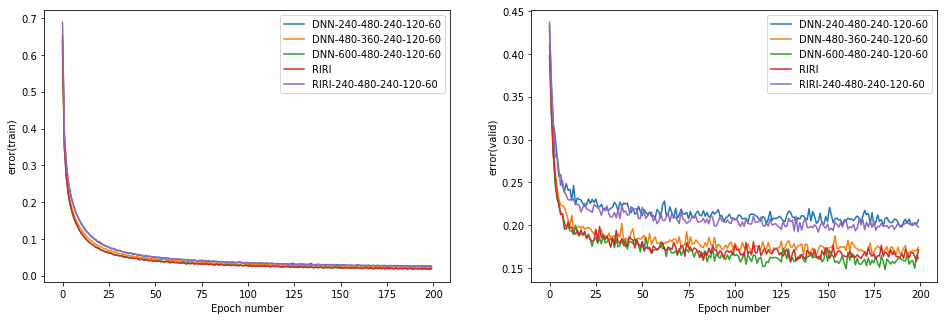

In [27]:
plot_whole(dictData)

(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a27101198>)

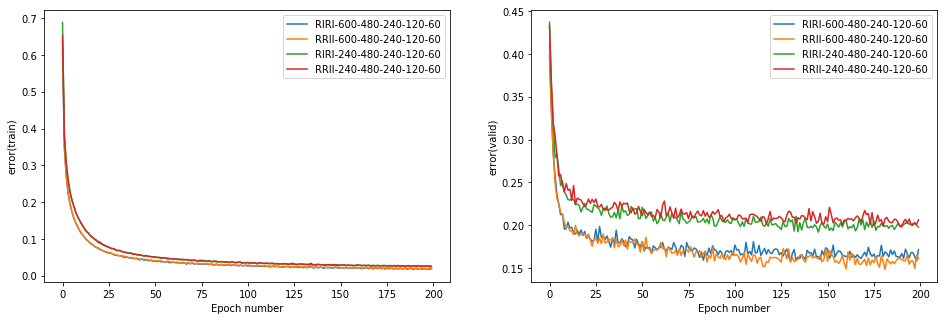

In [28]:
dictData2={}
dictData2['RIRI-600-480-240-120-60']=dictData['RIRI']
dictData2['RRII-600-480-240-120-60']=dictData['DNN-600-480-240-120-60']
dictData2['RIRI-240-480-240-120-60']=dictData['RIRI-240-480-240-120-60']
dictData2['RRII-240-480-240-120-60']=dictData['DNN-240-480-240-120-60']
plot_whole(dictData2)


(<Figure size 1152x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a26e0e278>)

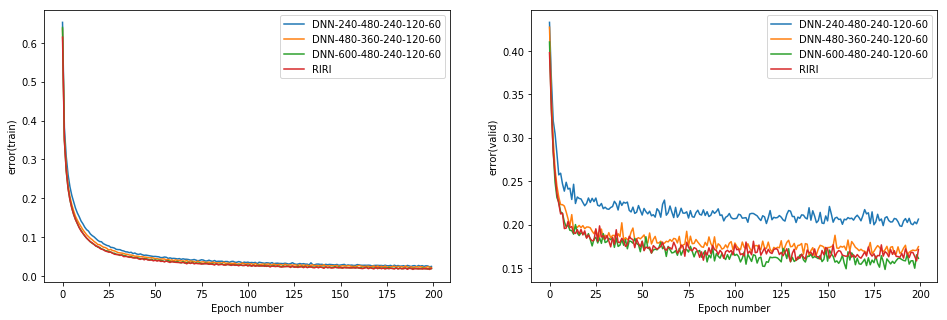

In [25]:
np.savez( "0803FiveLayers_sturcture.npz", data= dictData )
d = np.load( "0803FiveLayers_sturcture.npz" )
for sturctuers in sorted( d.items() ):
    val = sturctuers[1][()]
plot_whole(val)

In [5]:

model4layers = Sequential()
# activation=keras.layers.ReLU()
model4layers.add(Dense(480, input_dim=24, activation='relu'))
model4layers.add(Dense(240, activation='relu'))
model4layers.add(Dense(120, activation='relu'))
model4layers.add(Dense(60, activation='relu'))
model4layers.add(Dense(24, activation='linear'))
model4layers.summary()
adam=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
model4layers.compile(loss='mse', optimizer='adam')
hist=model4layers.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoencod')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-480-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 480)               12000     
_________________________________________________________________
dense_7 (Dense)              (None, 240)               115440    
_________________________________________________________________
dense_8 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_9 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1464      
Total params: 165,084
Trainable params: 165,084
Non-trainable params: 0
_________________________________________________________________
Train on 90000 samples, validate on 10000 samples
Epoch 1/200
90000/90000 [==============================] - 13s 141us/step - loss: 0.64

Epoch 141/200
90000/90000 [==============================] - 11s 122us/step - loss: 0.0365 - val_loss: 0.1865
Epoch 142/200
90000/90000 [==============================] - 11s 121us/step - loss: 0.0380 - val_loss: 0.1840
Epoch 143/200
90000/90000 [==============================] - 11s 121us/step - loss: 0.0365 - val_loss: 0.1806
Epoch 144/200
90000/90000 [==============================] - 11s 122us/step - loss: 0.0364 - val_loss: 0.1777
Epoch 145/200
90000/90000 [==============================] - 11s 122us/step - loss: 0.0357 - val_loss: 0.1778
Epoch 146/200
90000/90000 [==============================] - 11s 124us/step - loss: 0.0370 - val_loss: 0.1787
Epoch 147/200
90000/90000 [==============================] - 11s 123us/step - loss: 0.0366 - val_loss: 0.1794
Epoch 148/200
90000/90000 [==============================] - 11s 124us/step - loss: 0.0357 - val_loss: 0.1795
Epoch 149/200
90000/90000 [==============================] - 11s 123us/step - loss: 0.0359 - val_loss: 0.1845
Epoch 150/

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a30587080>)

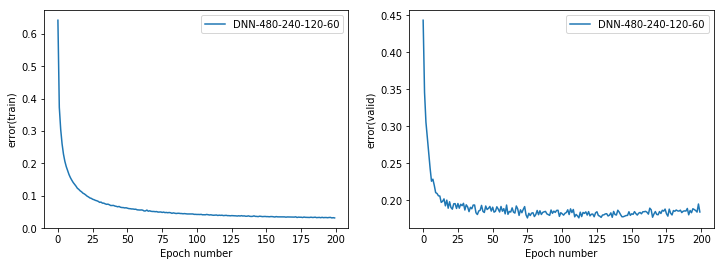

In [6]:
plot_whole(dictData)

In [7]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model5layers2 = Sequential()
# activation=keras.layers.ReLU()

model5layers2.add(Dense(480, input_dim=24, activation='relu'))
model5layers2.add(Dense(360, activation='relu'))
model5layers2.add(Dense(240, activation='relu'))
model5layers2.add(Dense(120, activation='relu'))
model5layers2.add(Dense(60, activation='relu'))
model5layers2.add(Dense(24, activation='linear'))
model5layers2.summary()
adam=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
model5layers2.compile(loss='mse', optimizer='adam')
hist=model5layers2.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoenco')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-480-360-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 480)               12000     
_________________________________________________________________
dense_12 (Dense)             (None, 360)               173160    
_________________________________________________________________
dense_13 (Dense)             (None, 240)               86640     
_________________________________________________________________
dense_14 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                1464      
Total params: 309,444
Trainable params: 309,444
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 140/200
90000/90000 [==============================] - 14s 155us/step - loss: 0.0262 - val_loss: 0.1737
Epoch 141/200
90000/90000 [==============================] - 14s 157us/step - loss: 0.0268 - val_loss: 0.1692
Epoch 142/200
90000/90000 [==============================] - 23s 255us/step - loss: 0.0265 - val_loss: 0.1852
Epoch 143/200
90000/90000 [==============================] - 19s 213us/step - loss: 0.0269 - val_loss: 0.1665
Epoch 144/200
90000/90000 [==============================] - 18s 204us/step - loss: 0.0250 - val_loss: 0.1772
Epoch 145/200
90000/90000 [==============================] - 18s 205us/step - loss: 0.0266 - val_loss: 0.1735
Epoch 146/200
90000/90000 [==============================] - 18s 204us/step - loss: 0.0276 - val_loss: 0.1722
Epoch 147/200
90000/90000 [==============================] - 18s 205us/step - loss: 0.0243 - val_loss: 0.1703
Epoch 148/200
90000/90000 [==============================] - 19s 208us/step - loss: 0.0257 - val_loss: 0.1705
Epoch 149/

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a26e92898>)

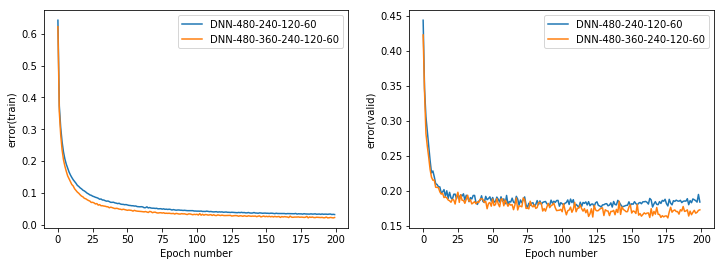

In [8]:
plot_whole(dictData)

In [9]:
from keras.layers import Input, Dense

model6layers = Sequential()
# activation=keras.layers.ReLU()

model6layers.add(Dense(600, input_dim=24, activation='relu'))
model6layers.add(Dense(480, activation='relu'))
model6layers.add(Dense(360, activation='relu'))
model6layers.add(Dense(240, activation='relu'))
model6layers.add(Dense(120, activation='relu'))
model6layers.add(Dense(60, activation='relu'))
model6layers.add(Dense(24, activation='linear'))
model6layers.summary()
adam=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
model6layers.compile(loss='mse', optimizer='adam')
hist=model6layers.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoen')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-600-480-360-240-120-60']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 600)               15000     
_________________________________________________________________
dense_18 (Dense)             (None, 480)               288480    
_________________________________________________________________
dense_19 (Dense)             (None, 360)               173160    
_________________________________________________________________
dense_20 (Dense)             (None, 240)               86640     
_________________________________________________________________
dense_21 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_22 (Dense)             (None, 60)                7260      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                1464      
Total para

Epoch 139/200
90000/90000 [==============================] - 25s 275us/step - loss: 0.0239 - val_loss: 0.1875
Epoch 140/200
90000/90000 [==============================] - 25s 275us/step - loss: 0.0235 - val_loss: 0.1830
Epoch 141/200
90000/90000 [==============================] - 25s 275us/step - loss: 0.0241 - val_loss: 0.1849
Epoch 142/200
90000/90000 [==============================] - 25s 276us/step - loss: 0.0228 - val_loss: 0.1897
Epoch 143/200
90000/90000 [==============================] - 25s 276us/step - loss: 0.0257 - val_loss: 0.1793
Epoch 144/200
90000/90000 [==============================] - 25s 276us/step - loss: 0.0212 - val_loss: 0.1731
Epoch 145/200
90000/90000 [==============================] - 25s 276us/step - loss: 0.0220 - val_loss: 0.1837
Epoch 146/200
90000/90000 [==============================] - 25s 274us/step - loss: 0.0245 - val_loss: 0.1929
Epoch 147/200
90000/90000 [==============================] - 25s 275us/step - loss: 0.0230 - val_loss: 0.1942
Epoch 148/

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a26e7def0>)

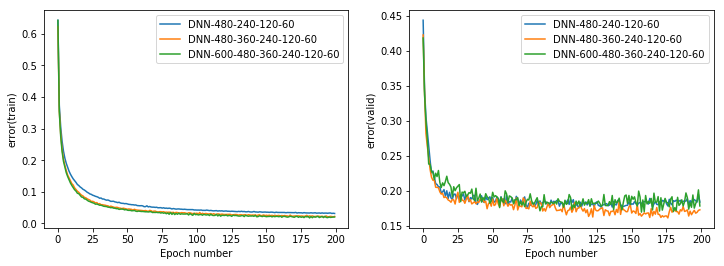

In [10]:
plot_whole(dictData)

In [11]:
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard
from keras.models import Model
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
model7layers = Sequential()
activation=keras.layers.elu()

model7layers.add(Dense(720, input_dim=24, activation='relu'))
model7layers.add(Dense(600, activation=activation))
model7layers.add(Dense(480, activation=activation))
model7layers.add(Dense(360, activation=activation))
model7layers.add(Dense(240, activation=activation))
model7layers.add(Dense(120, activation=activation))
model7layers.add(Dense(60, activation=activation))
model7layers.add(Dense(24, activation='linear'))
model7layers.summary()
adam=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
model7layers.compile(loss='mse', optimizer='adam')
hist=model7layers.fit(x_train, y_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='/tmp/autoe')])
# model.fit(x_train, y_train, epochs=100, verbose=0)
dictData['DNN-720-600-480-360-240-120-60-elu']=hist.history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 720)               18000     
_________________________________________________________________
dense_25 (Dense)             (None, 600)               432600    
_________________________________________________________________
dense_26 (Dense)             (None, 480)               288480    
_________________________________________________________________
dense_27 (Dense)             (None, 360)               173160    
_________________________________________________________________
dense_28 (Dense)             (None, 240)               86640     
_________________________________________________________________
dense_29 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_30 (Dense)             (None, 60)                7260      
__________

90000/90000 [==============================] - 44s 486us/step - loss: 0.0223 - val_loss: 0.1873
Epoch 137/200
90000/90000 [==============================] - 41s 461us/step - loss: 0.0230 - val_loss: 0.1895
Epoch 138/200
90000/90000 [==============================] - 43s 479us/step - loss: 0.0282 - val_loss: 0.1919
Epoch 139/200
90000/90000 [==============================] - 49s 545us/step - loss: 0.0220 - val_loss: 0.1996
Epoch 140/200
90000/90000 [==============================] - 47s 518us/step - loss: 0.0229 - val_loss: 0.1849
Epoch 141/200
90000/90000 [==============================] - 49s 542us/step - loss: 0.0225 - val_loss: 0.1895
Epoch 142/200
90000/90000 [==============================] - 48s 528us/step - loss: 0.0253 - val_loss: 0.1771
Epoch 143/200
90000/90000 [==============================] - 49s 550us/step - loss: 0.0210 - val_loss: 0.1770
Epoch 144/200
90000/90000 [==============================] - 51s 561us/step - loss: 0.0263 - val_loss: 0.1913
Epoch 145/200
90000/9000

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a328197b8>)

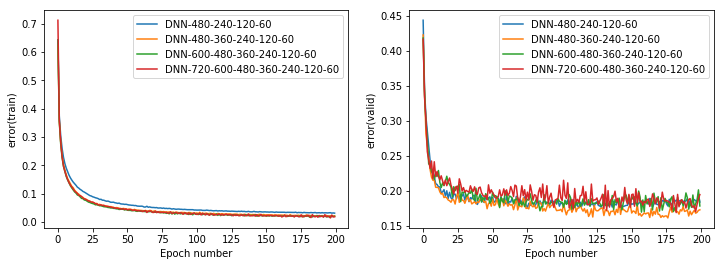

In [12]:
plot_whole(dictData)